In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [57]:
# Setting hyperparameters
batch_size = 32
epochs = 5
learning_rate = 0.0001
l1 = False
l2 = False
lr_decay = False

In [58]:
from google.colab import drive
drive.mount('/content/drive')


path = 'drive/MyDrive/Code/Dataset/bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
df1 = pd.read_csv(path)

df = df1.dropna(how="any")

print(df.shape)
df.isnull().sum()

(3613769, 8)


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [66]:
# Generating dataset

class bitcoin(Dataset):
    def __init__(self, X, window):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window+1
        # print(self.len)
        for i in range(0, X.shape[0]-window-1):
          self.X.append(X[i:window+i])
          self.y.append(X[window+i])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # print(index)
        # print(self.X[index])
        # print(self.y[index])
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [67]:
train = bitcoin(df["Weighted_Price"].iloc[:2700000].to_numpy(), 70)

In [68]:
val = bitcoin(df["Weighted_Price"].iloc[2700000:2750000].to_numpy(), 70)

In [69]:
test = bitcoin(df["Weighted_Price"].iloc[2750000:2800000].to_numpy(), 70)

In [70]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [71]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([32, 70]) torch.Size([32, 1])


In [72]:
class RNNForecasting(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_shape, hidden_shape, num_layers=num_layers)
        self.linear = nn.Linear(hidden_shape, output_shape)

    def forward(self, x, future=0):
        h = torch.zeros([self.num_layers, self.hidden]).cuda()
        # print(f"ff {h.dtype}")
        out, h = self.rnn(x, h)
        out = self.linear(out)

        return out

    def compute_l1(self, w):
        return torch.abs(w).sum()

    def compute_l2(self, w):
      return torch.square(w).sum()

In [73]:
input_shape = 70
hidden_shape = 128
model = RNNForecasting(input_shape, hidden_shape, 1, num_layers=3).cuda()

In [74]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

In [75]:
# Training
l1_weight = 0.01
l2_weight = 0.01
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # print(batch_x.dtype)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        # y_pred = y_pred.squeeze(1)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        if l1:
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
            l += L1

        # Using l2 regularization
        if l2:
            l2_parameters = []
            for parameter in model.parameters():
                l2_parameters.append(parameter.view(-1))
            L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
            l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    if lr_decay:
        epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Iter: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iter:  0 train:  2765.8495471464225 val:  6024.939554014956
Iter:  1 train:  3258.588003621404 val:  6034.317442197615
Iter:  2 train:  3255.946315445163 val:  6034.309245793166
Iter:  3 train:  3255.9483992581745 val:  6034.308759665344
Iter:  4 train:  3255.948439226285 val:  6034.308759665344


33374678.0 5734.725


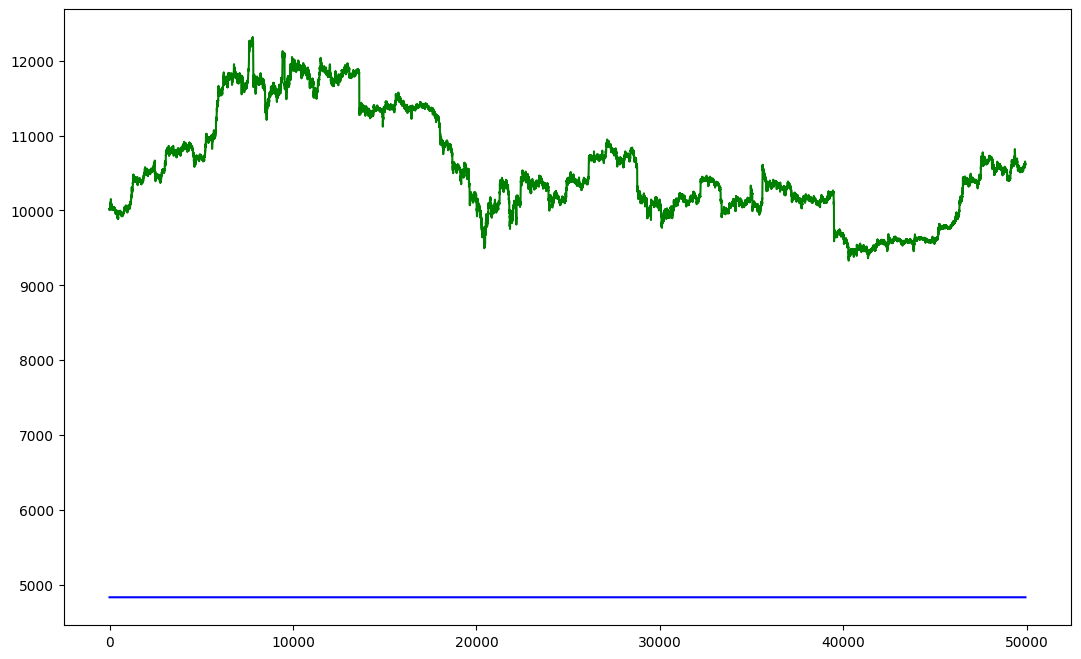

In [77]:
# Testing the model

with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

    plt.figure(figsize=(13, 8))
    plt.plot(preds, 'b', label='line 1')
    plt.plot(true, 'g',  label='line 2')
    plt.show()